# BIA 6304 Predictive Models Fall 2017
## Assignment 2 Safe Driver Dataset
### Stuent:  Leonardo Ji
### 11/10/2017

### Import Standard packages

In [2]:
#Add packages
#These are my standard packages I load for almost every project
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 15000) #important for getting all the text
import seaborn as sns
color = sns.color_palette()
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
import time
#Notice I did not load my Datamining packages yet (ie decision tree). I will do that as I use them.

### Using your favorite analytic tool(s)….. (meaning you can use scikit-learn or R).

The goal of this assignment is to take a decent sized dataset (several feature and instances) and apply multiple TUNED classification models to find the best one. (You will also need to defend how you determine the “best”*). 

#### Dataset: 

porto-seguro safe driver dataset: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction.

#### Task: 

1)	Preprocess and EDA data as needed. Don’t just do EDA, discuss what it tell you about the data and how it informs you in different decisions you make about the below models. 

2)	Run and tune at least the below methods. You will create several different tuning of each. Like KNN-3 AND KNN-5, using different distance measurements, Or SVM with kernels, cost functions and gammas, OR Random Forest with different "trys". Report your best tuned model for each. Don’t forget to CV. If you just did three tunings per model, you would be trying 36 different models on this dataset. That is probably a minimum. Grid search is your friend, but also your enemy if you ask it to search through too much. This is a great way to learn how to balance the two. 

* KNN 
* Decision Tree 
* Random Forest
* SVM Linear
* SVM RBF (be careful on this one as it will be slow to train. Think of ways to work around this limitation) 
* Adaboost (use at least two different learners)
* Bagging Classifier (choose at least one learner)
* Extra Trees
* Gradient Boosting 
* ANN (different hidden layers and nodes)
* Stochastic Gradient Descent
* Stacking

### Import Data

In [3]:
train_df = pd.read_csv('../input/train.csv')
train_df.shape

FileNotFoundError: [Errno 2] No such file or directory: '../input/train.csv'

In [3]:
train_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
print(train_df.columns)

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


### Exploratory data analysis

In [5]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,49
1,float64,10


In [6]:
vars_with_missing = []

for attName in train_df.columns:
    missings = train_df[train_df[attName] == -1][attName].count()
    if missings > 0:
        vars_with_missing.append(attName)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(attName, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


#### The target variable is a binary variable 0 or 1.

In [7]:
train_df.target.unique()

array([0, 1], dtype=int64)

#### more target = 0 than target = 0.  We will look for models have higher Sensitivity and Precision ratios on target = 1.
$$Sensitivity  = \frac{True Positive}{True Positive + False Negative}$$
$$Precision = \frac{True Positive}{True Positive + False Positive}$$

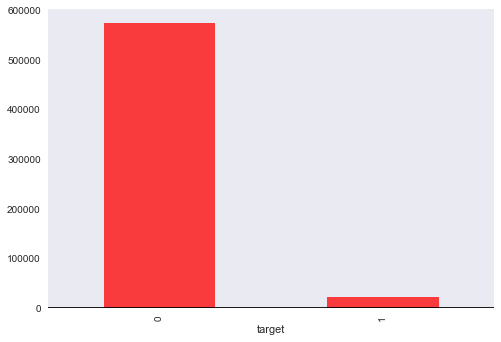

In [8]:
groupby = train_df.groupby('target')
targetEDA=groupby['target'].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False, color='red', alpha=0.75)
plt.axhline(0, color='black')

### Preprocessing
#### Remove -1 and replace with nan

In [9]:
for attName in train_df.columns:
    missings = train_df[train_df[attName] == -1][attName].count()
    if missings > 0:
        train_df[attName] = train_df[attName].replace(-1, np.nan)

In [10]:
train_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


#### Separate categorical variables and continuous variables.

In [11]:
continusCol = []
catCol = []
for attName in train_df.columns[2:]:
    dType = train_df[attName].dtype
    # discretize (create dummies) for all categorical columns
    if 'cat' in attName:
        catCol.append(attName)
    elif 'bin' in attName or train_df[attName].dtype == float or train_df[attName].dtype == int:
        continusCol.append(attName)
print("Categorical variables: ", catCol)
print("Continuous variables: ", continusCol)

Categorical variables:  ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
Continuous variables:  ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


#### Collinearity analysis on all continuous variables.
Darker the color higher the correlations.
ps_ind_16_bin and ps_ind_18_bin, ps_reg_02 and ps_reg_03, ps_car_12 and ps_car_13, ps_car_12 and ps_car_14, ps_car_13 and ps_car_15 show strong correlations.

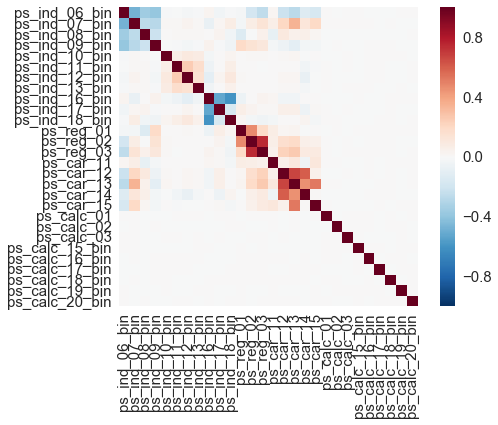

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
sns.set(font_scale=1.5)
hm = sns.heatmap(train_df[continusCol].corr(), 
            cbar=True,
            annot=False,
            square=True,
            fmt='.2f')
plt.show()

In [13]:
train_df=train_df.drop(['ps_ind_16_bin', 'ps_reg_02', 'ps_car_12', 'ps_car_15'], axis=1)

#### Convert categorical variables to dummy columns.

In [14]:
for attName in train_df.columns[2:]:
    dType = train_df[attName].dtype
    # discretize (create dummies) for all categorical columns
    if 'cat' in attName:
        #print(attName)
        train_df = pd.concat([train_df, pd.get_dummies(train_df[attName], prefix=attName)], axis=1)
        del train_df[attName]
train_df.shape

(595212, 216)

#### Convert all feature columns to float, and replace nan with mean.

In [15]:
for attName in train_df.columns:
    dType = train_df[attName].dtype
    if pd.isnull(train_df[attName]).any():
        train_df[attName] = train_df[attName].fillna(train_df[attName].mean())

#### Handling imbalanced target classes
There are way more target = 0 than target = 1.
We can randomly sample over represented target = 0 rows to combine with all target = 1 rows to get a balanced training dataset.

In [16]:
# Get the indices per target value
index_0 = train_df[train_df.target == 0].index
index_1 = train_df[train_df.target == 1].index

# Get original number of records per target value
total_number_0 = len(train_df.loc[index_0])
total_number_1 = len(train_df.loc[index_1])
print('Total number of row target = 0: ', total_number_0)
print('Total number of row target = 1: ', total_number_1)
print('Percentile of target = 1: ', total_number_1/len(train_df))
print('Percentile of target = 0: ', total_number_0/len(train_df))

Total number of row target = 0:  573518
Total number of row target = 1:  21694
Percentile of target = 1:  0.036447517859182946
Percentile of target = 0:  0.963552482140817


$$targetNumber = \frac{(1-targetRatio)*numberOfTarget1}{underSamplingRatio*numberOfTarget0}$$

In [17]:
desired_apriori=0.5
# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*total_number_1)/(total_number_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*total_number_0)
print('Rate to undersample records with target = 0: ', format(undersampling_rate))
print('Number of records with target = 0 after undersampling: ', format(undersampled_nb_0))

Rate to undersample records with target = 0:  0.037826188541597645
Number of records with target = 0 after undersampling:  21694


In [18]:
# Randomly select records with target=0 to get at the desired a priori
# This reduce number of target = 0
undersampled_idx = shuffle(index_0, random_state=42, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(index_1)

# Return undersample data frame
dataset = train_df.loc[idx_list].reset_index(drop=True)

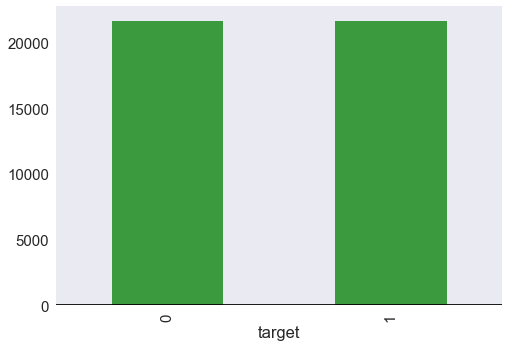

In [19]:
groupby = dataset.groupby('target')
targetEDA=groupby['target'].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False, color='green', alpha=0.75)
plt.axhline(0, color='black')

### Create Train/Test split

In [20]:
dataset.target=dataset['target'] 
dataset.features=dataset.iloc[:, 2:]                        
print(dataset.target.shape)
print(dataset.features.shape)
print(dataset.features.columns)

(43388,)
(43388, 214)
Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin',
       ...
       'ps_car_11_cat_95', 'ps_car_11_cat_96', 'ps_car_11_cat_97',
       'ps_car_11_cat_98', 'ps_car_11_cat_99', 'ps_car_11_cat_100',
       'ps_car_11_cat_101', 'ps_car_11_cat_102', 'ps_car_11_cat_103',
       'ps_car_11_cat_104'],
      dtype='object', length=214)


In [21]:
from sklearn.cross_validation import train_test_split

X = dataset.features
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Run KNN Model using train/test 
KNN Model 3 K = 7 is the best model based on results from 10-fold cv.

#### KNN model 1: K = 3

In [39]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
clf_knn = KNeighborsClassifier(n_neighbors=3, p = 1)
clf_knn.fit(X_train, y_train)
print(clf_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')


In [40]:
# make predictions
knn_expected = y_test
knn_predicted = clf_knn.predict(X_test)
print(clf_knn.score(X_test, y_test))

0.526465391411


In [41]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn_expected, knn_predicted)))
print(metrics.classification_report(knn_expected, knn_predicted))

accuracy: 0.526465391411
             precision    recall  f1-score   support

          0       0.53      0.56      0.54      6517
          1       0.53      0.49      0.51      6500

avg / total       0.53      0.53      0.53     13017



#### Verify with 10-fold Cross Validation
All 10-folds results within 1.2 percentage from mean and this means the model does not overfit.

In [42]:
scores = cross_val_score(clf_knn, X_train, y_train, cv=10)

In [43]:
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.52732061  0.51514154  0.53028308  0.53390388  0.52387224  0.53177478
  0.52090879  0.53458498  0.5428195   0.5240448 ]
Cross Validation Score mean:  0.528465419828
Cross Validation Max and Min Score difference from mean score:  0.0133238793404 0.0143540795136


#### KNN model 2: K = 5

In [44]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 5)
clf_knn = KNeighborsClassifier(n_neighbors=5, p = 1)
clf_knn.fit(X_train, y_train)
print(clf_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')


In [45]:
# make predictions
knn_expected = y_test
knn_predicted = clf_knn.predict(X_test)
print(clf_knn.score(X_test, y_test))

0.532611200737


In [46]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn_expected, knn_predicted)))
print(metrics.classification_report(knn_expected, knn_predicted))

accuracy: 0.532611200737
             precision    recall  f1-score   support

          0       0.53      0.58      0.56      6517
          1       0.54      0.48      0.51      6500

avg / total       0.53      0.53      0.53     13017



#### Verify with 10-fold Cross Validation
All 10-folds results within 1.5 percentage from mean and this means the model does not overfit.

In [47]:
scores = cross_val_score(clf_knn, X_train, y_train, cv=10)

In [48]:
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.53324556  0.5283081   0.53719552  0.53028308  0.5255186   0.55087257
  0.5195917   0.52437418  0.53754941  0.54380764]
Cross Validation Score mean:  0.53307463612
Cross Validation Max and Min Score difference from mean score:  0.0134829337823 0.0177979354966


#### KNN model: K = 7

In [49]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 7)
clf_knn = KNeighborsClassifier(n_neighbors=7, p = 1)
clf_knn.fit(X_train, y_train)
print(clf_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=1,
           weights='uniform')


In [50]:
# make predictions
knn_expected = y_test
knn_predicted = clf_knn.predict(X_test)
print(clf_knn.score(X_test, y_test))

0.53368671737


In [51]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn_expected, knn_predicted)))
print(metrics.classification_report(knn_expected, knn_predicted))

accuracy: 0.53368671737
             precision    recall  f1-score   support

          0       0.53      0.60      0.56      6517
          1       0.54      0.47      0.50      6500

avg / total       0.53      0.53      0.53     13017



#### Verify with 10-fold Cross Validation
All 10-folds results within 1 percentage from mean and this means the model does not overfit.

In [52]:
scores = cross_val_score(clf_knn, X_train, y_train, cv=10)

In [53]:
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.54081633  0.54213298  0.53982883  0.5355497   0.53704313  0.55087257
  0.53770168  0.53820817  0.55566535  0.55467721]
Cross Validation Score mean:  0.543249595748
Cross Validation Max and Min Score difference from mean score:  0.00769989199588 0.0124157533953


### Run Decision Tree Model using train/test 
Decision Tree Model 2 is the best model based on 10-fold cv.

#### Decision Tree Model 1

In [22]:
#Decision Tree train model. Call up my model and name it clf
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_split= 5, min_samples_leaf=3)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_dt)
#Fit clf to the training data
clf_dt = clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [23]:
# make predictions
dt_expected = y_test
dt_predicted = clf_dt.predict(X_test)
print(clf_dt.score(X_test, y_test))

0.571637089959


In [24]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

accuracy: 0.571637089959
             precision    recall  f1-score   support

          0       0.56      0.66      0.61      6517
          1       0.59      0.48      0.53      6500

avg / total       0.57      0.57      0.57     13017



##### Verify with 10-fold Cross Validation
All 10-folds results within 1.5 percentage from mean and this means the model does not overfit.

In [25]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.56879526  0.57899934  0.57998683  0.58196182  0.59236088  0.58281199
  0.56931182  0.5668643   0.57279315  0.58003953]
Cross Validation Score mean:  0.577392491067
Cross Validation Max and Min Score difference from mean score:  0.0105281959423 0.0149683913824


#### Decision Tree plot helps us understand important features and branch conditions.

In [25]:
from sklearn import tree
from sklearn.tree import export_graphviz
from os import system
dot_data = tree.export_graphviz(clf_dt, feature_names=X_train.columns, 
                         filled=True, rounded=True,  
                         special_characters=True, out_file='tree.dot') 

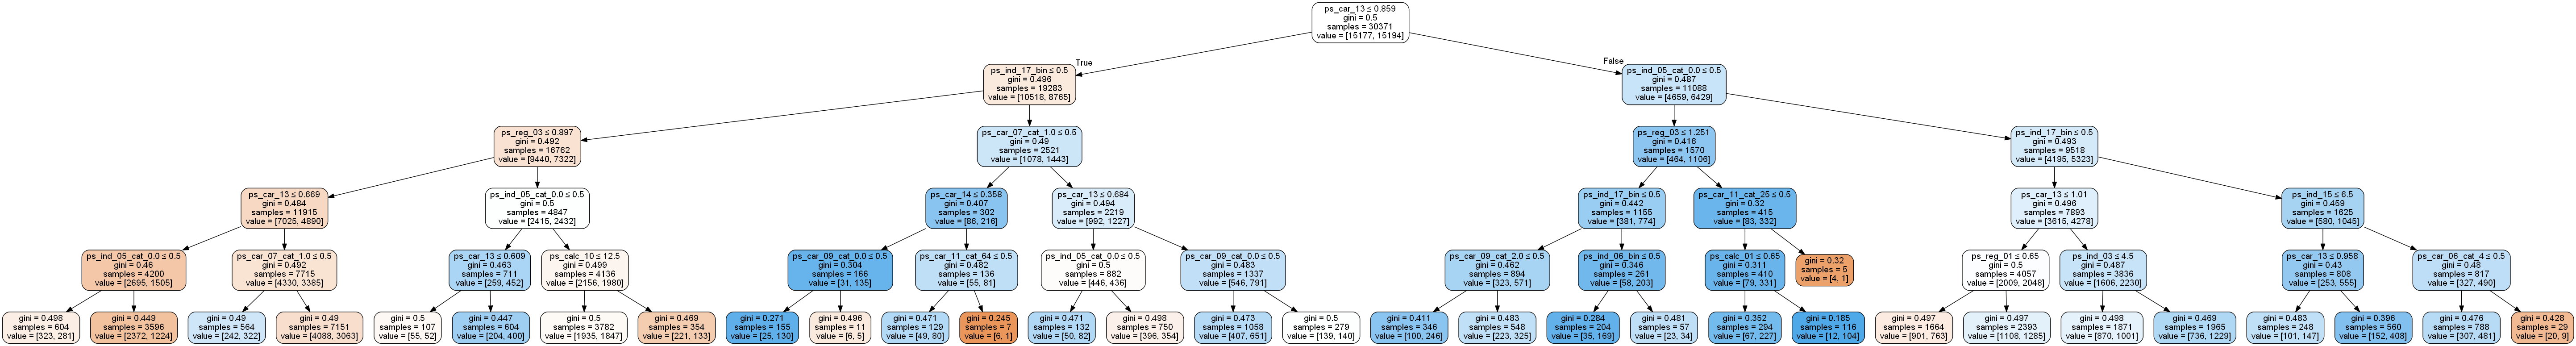

In [30]:
from os import system
system("dot -Tpng tree.dot -o dtree.png")
from IPython.display import Image
Image("dtree.png")

#### Decision Tree Model 2

In [58]:
#Decision Tree train model. Call up my model and name it clf
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split= 5)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_dt)
#Fit clf to the training data
clf_dt = clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [59]:
# make predictions
dt_expected = y_test
dt_predicted = clf_dt.predict(X_test)
print(clf_dt.score(X_test, y_test))

0.525927633095


In [60]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

accuracy: 0.525927633095
             precision    recall  f1-score   support

          0       0.53      0.53      0.53      6517
          1       0.53      0.52      0.52      6500

avg / total       0.53      0.53      0.53     13017



##### Verify with 10-fold Cross Validation
All 10-folds results within 1 percentage from mean and this means the model does not overfit.

In [61]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.51942067  0.52764977  0.53752469  0.53061224  0.52255515  0.53243332
  0.53078696  0.53326746  0.52173913  0.52536232]
Cross Validation Score mean:  0.528135171601
Cross Validation Max and Min Score difference from mean score:  0.00871450010695 0.00938951569292


#### Decision Tree Model 3

In [62]:
#Decision Tree train model. Call up my model and name it clf
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier(criterion='gini', min_samples_split= 5, min_samples_leaf=3)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_dt)
#Fit clf to the training data
clf_dt = clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [376]:
# make predictions
dt_expected = y_test
dt_predicted = clf_dt.predict(X_test)
print(clf_dt.score(X_test, y_test))

0.532457555504


In [377]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

accuracy: 0.532457555504
             precision    recall  f1-score   support

          0       0.53      0.55      0.54      6517
          1       0.53      0.52      0.52      6500

avg / total       0.53      0.53      0.53     13017



##### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means this model is not as good (on overfitting) as previous decision model.

In [65]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.51744569  0.51942067  0.54279131  0.53094141  0.52881133  0.53605532
  0.53967731  0.50922266  0.53557312  0.51054018]
Cross Validation Score mean:  0.527047900457
Cross Validation Max and Min Score difference from mean score:  0.0178252390608 0.0157434096151


### Run Random Forest Model using the above created train/test 
Random Forest Model 3 is the best model based on 10-fold cv and Recall and Precision Ratios.

#### Random Forest model 1

In [66]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(min_samples_leaf = 5, min_samples_split = 5, 
                                      random_state = 42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [67]:
clf_rf_expected = y_test
clf_rf_predicted = clf_rf.predict(X_test)
print(clf_rf.score(X_test, y_test))
#print(clf_rf.feature_importances_)

0.563493892602


In [68]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_rf_expected, clf_rf_predicted)))
print(metrics.classification_report(clf_rf_expected, clf_rf_predicted))

accuracy: 0.563493892602
             precision    recall  f1-score   support

          0       0.56      0.56      0.56      6517
          1       0.56      0.57      0.57      6500

avg / total       0.56      0.56      0.56     13017



#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from its mean the model is not overfitting.

In [69]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.54443713  0.57439105  0.58262014  0.5638578   0.57095818  0.57293382
  0.57458018  0.55500659  0.56258235  0.57147563]
Cross Validation Score mean:  0.567284285757
Cross Validation Max and Min Score difference from mean score:  0.0228471560663 0.0153358590753


#### Random Forest model 2

In [70]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(min_samples_leaf = 5, min_samples_split = 10, max_features= 'sqrt', 
                                n_estimators=50, oob_score = True, random_state = 42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [71]:
clf_rf_expected = y_test
clf_rf_predicted = clf_rf.predict(X_test)
print(clf_rf.score(X_test, y_test))
#print(clf_rf.feature_importances_)

0.585157870477


In [72]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_rf_expected, clf_rf_predicted)))
print(metrics.classification_report(clf_rf_expected, clf_rf_predicted))

accuracy: 0.585157870477
             precision    recall  f1-score   support

          0       0.59      0.58      0.58      6517
          1       0.58      0.59      0.59      6500

avg / total       0.59      0.59      0.59     13017



#### Verify with 10-fold Cross Validation
All 10-folds results within 1.5% from its mean the model is not overfitting.

In [73]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.57472021  0.59776169  0.5921659   0.58229098  0.59005598  0.59697069
  0.59301943  0.58036891  0.59782609  0.59519104]
Cross Validation Score mean:  0.590037090789
Cross Validation Max and Min Score difference from mean score:  0.015316880124 0.00778899616763


#### Run Grid Search to find parameters for Random Forest

In [74]:
start_time = time.clock()
rfc = RandomForestClassifier(min_samples_leaf = 5, min_samples_split = 10, n_jobs=-1, 
                             max_features= 'sqrt' ,n_estimators=50, random_state=42) 
param_grid = { 
    'min_samples_leaf': [10, 20],
    'min_samples_split': [5, 10],
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print("SCORES", CV_rfc.cv_results_)
print("BEST SCORE", CV_rfc.best_score_)
print("BEST PARAM", CV_rfc.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'split0_test_score': array([ 0.58979424,  0.59786008,  0.59259259,  0.58979424,  0.59786008,
        0.59259259,  0.59390947,  0.59028807,  0.59193416,  0.59390947,
        0.59028807,  0.59193416,  0.58979424,  0.59786008,  0.59259259,
        0.58979424,  0.59786008,  0.59259259,  0.59390947,  0.59028807,
        0.59193416,  0.59390947,  0.59028807,  0.59193416,  0.58238683,
        0.5837037 ,  0.58995885,  0.58238683,  0.5837037 ,  0.58995885,
        0.58880658,  0.58567901,  0.58485597,  0.58880658,  0.58567901,
        0.58485597]), 'split1_test_score': array([ 0.59539095,  0.59769547,  0.59423868,  0.59539095,  0.59769547,
        0.59423868,  0.58814815,  0.59176955,  0.59555556,  0.58814815,
        0.59176955,  0.59555556,  0.59539095,  0.59769547,  0.59423868,
        0.59539095,  0.59769547,  0.59423868,  0.58814815,  0.59176955,
        0.59555556,  0.58814815,  0.59176955,  0.59555556,  0.58897119,
        0.5909465 ,  0.59259259,  0.58897119,  0.5909465 ,  0.59

#### Random Forest model 3 - with Grid Search found parameters

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(min_samples_leaf = 10, min_samples_split = 5, max_features= 'auto', 
                                n_estimators=500, oob_score = True, random_state = 42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [28]:
clf_rf_expected = y_test
clf_rf_predicted = clf_rf.predict(X_test)
print(clf_rf.score(X_test, y_test))
#print(clf_rf.feature_importances_)

0.594222939233


In [29]:
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_rf_expected, clf_rf_predicted)))
print(metrics.classification_report(clf_rf_expected, clf_rf_predicted))

accuracy: 0.591606747788
             precision    recall  f1-score   support

          0       0.59      0.60      0.59      7232
          1       0.59      0.59      0.59      7232

avg / total       0.59      0.59      0.59     14464



#### Verify with 10-fold Cross Validation
All 10-folds results within 1.1 percentage from its mean the model is not overfitting.

In [78]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58722844  0.59611587  0.59776169  0.58525346  0.59433652  0.59433652
  0.59071452  0.58860343  0.60046113  0.60573123]
Cross Validation Score mean:  0.594054278444
Cross Validation Max and Min Score difference from mean score:  0.00880082222256 0.0116769468527


#### Random Forest model gives us what are important features variables.

In [29]:
importance = clf_rf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf_rf.estimators_], axis=0)
importance.head(50)

,Importance,Std
ps_ind_01,0.024880,0.005643
ps_ind_03,0.035875,0.007016
ps_ind_06_bin,0.012973,0.008524
ps_ind_07_bin,0.013039,0.008519
ps_ind_08_bin,0.005461,0.002686
ps_ind_09_bin,0.005188,0.002659
ps_ind_10_bin,0.000000,0.000000
ps_ind_11_bin,0.000004,0.000068
ps_ind_12_bin,0.000225,0.000570
ps_ind_13_bin,0.000000,0.000000


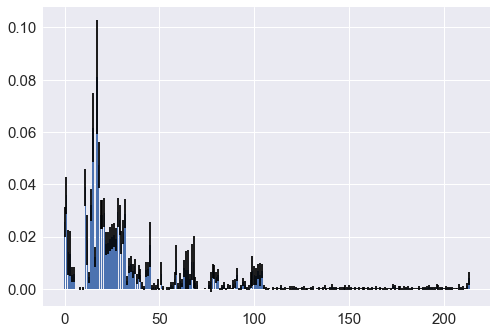

In [37]:
x = range(importance.shape[0])
y = importance.iloc [:, 0]
yerr = importance.iloc[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

### Run Linear SVM Model using train/test 
Linear SVM Model 3 is the best model based on precision and recall ratios.

#### Linear SVM Model 1

In [59]:
from sklearn.svm import LinearSVC
clf_linSVC=LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, class_weight='balanced')
clf_linSVC.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [60]:
predicted_SVC=clf_linSVC.predict(X_test)
clf_linSVC_expected = y_test
print(accuracy_score(clf_linSVC_expected,predicted_SVC))

0.556503034493


In [61]:
# summarize the fit of the model
print(classification_report(clf_linSVC_expected, predicted_SVC,target_names=['No', 'Yes']))
print(confusion_matrix(clf_linSVC_expected, predicted_SVC))

             precision    recall  f1-score   support

         No       0.53      0.89      0.67      6517
        Yes       0.66      0.23      0.34      6500

avg / total       0.60      0.56      0.50     13017

[[5771  746]
 [5027 1473]]


#### Linear SVM Model 2

In [253]:
from sklearn.svm import SVC
clf_linSVC=SVC(kernel='linear', C=0.01, class_weight=None, gamma='auto')
clf_linSVC.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [254]:
predicted_SVC=clf_linSVC.predict(X_test)
clf_linSVC_expected = y_test
print(accuracy_score(clf_linSVC_expected,predicted_SVC))

0.592532841669


In [255]:
# summarize the fit of the model
print(classification_report(clf_linSVC_expected, predicted_SVC,target_names=['No', 'Yes']))
print(confusion_matrix(clf_linSVC_expected, predicted_SVC))

             precision    recall  f1-score   support

         No       0.58      0.67      0.62      6517
        Yes       0.61      0.52      0.56      6500

avg / total       0.59      0.59      0.59     13017

[[4337 2180]
 [3124 3376]]


#### Grid Search Penalty Cost (slow took 3 hours)
Best cost parameter is 0.01.

In [62]:
start_time = time.clock()
from sklearn.svm import SVC
parameters = {'C':[.01,.05,1,5]}
svr = SVC(kernel='linear')
grid_svm = GridSearchCV(svr, parameters,n_jobs=-1, cv=3)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'split0_test_score': array([ 0.58790992,  0.58563809,  0.58405768,  0.58504544]), 'split1_test_score': array([ 0.58583564,  0.58425524,  0.58386013,  0.58287238]), 'split2_test_score': array([ 0.59241332,  0.5885607 ,  0.58737528,  0.58648622]), 'mean_test_score': array([ 0.5887195 ,  0.58615126,  0.58509763,  0.58480129]), 'std_test_score': array([ 0.00274565,  0.00179475,  0.00161249,  0.0014854 ]), 'rank_test_score': array([1, 2, 3, 4]), 'split0_train_score': array([ 0.59885415,  0.59989134,  0.60092853,  0.60117548]), 'split1_train_score': array([ 0.60161999,  0.60221267,  0.60413888,  0.60413888]), 'split2_train_score': array([ 0.59852825,  0.60168906,  0.60262742,  0.60292375]), 'mean_train_score': array([ 0.59966746,  0.60126436,  0.60256495,  0.60274604]), 'std_train_score': array([ 0.00138704,  0.00099412,  0.00131137,  0.00121631]), 'mean_fit_time': array([  560.29626679,   669.28279996,  3453.71758405,  8723.81906319]), 'std_fit_time': array([  12.14037947,    9.0743

#### Linear SVM Model 3 with Grid Search found Penalty Cost

In [138]:
from sklearn.svm import SVC
start_time = time.clock()
#standard linear SVC
clf_linSVC = SVC(kernel='linear', C=0.01, class_weight='balanced', gamma='auto')
clf_linSVC.fit(X_train, y_train)
predicted_SVC=clf_linSVC.predict(X_test)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 401.9545787580719 seconds


In [139]:
# summarize the fit of the model
clf_linSVC_expected = y_test
print(classification_report(clf_linSVC_expected, predicted_SVC, target_names=['No', 'Yes']))
print(confusion_matrix(clf_linSVC_expected, predicted_SVC))
print(accuracy_score(clf_linSVC_expected, predicted_SVC))

             precision    recall  f1-score   support

         No       0.58      0.67      0.62      6517
        Yes       0.61      0.52      0.56      6500

avg / total       0.59      0.59      0.59     13017

[[4346 2171]
 [3137 3363]]
0.592225551202


#### Verify with 10-fold Cross Validation
All 10-folds results within 1.5% from mean and this means the model is not overfitting.

In [158]:
scores = cross_val_score(clf_linSVC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58459513  0.59183673  0.59282423  0.58953259  0.58511689  0.58347053
  0.58544616  0.58168643  0.60540184  0.60046113]
Cross Validation Score mean:  0.590037166965
Cross Validation Max and Min Score difference from mean score:  0.00835073745259 0.0153646775672


### Run RBF SVM Model using train/test 
Decision Tree Model 3 is the best model based on precision and recall ratios.

#### RBF SVM Model 1

In [257]:
start_time = time.clock()
#rbf SVC
clf_rbf = SVC(kernel='rbf', C=1, class_weight=None)
clf_rbf.fit(X_train, y_train)
predicted_rbf=clf_rbf.predict(X_test)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 344.37290867113916 seconds


In [258]:
clf_rbf_expected = y_test
# summarize the fit of the model
print(classification_report(clf_rbf_expected, predicted_rbf, target_names=['No', 'Yes']))
print(confusion_matrix(clf_rbf_expected, predicted_rbf))
print(accuracy_score(clf_rbf_expected,predicted_rbf))

             precision    recall  f1-score   support

         No       0.59      0.66      0.62      6517
        Yes       0.61      0.54      0.57      6500

avg / total       0.60      0.60      0.59     13017

[[4271 2246]
 [3009 3491]]
0.596297149881


#### RBF SVM Model 2

In [259]:
start_time = time.clock()
#rbf SVC
clf_rbf = SVC(kernel='rbf', C=1, class_weight='balanced', degree = 5)
clf_rbf.fit(X_train, y_train)
predicted_rbf=clf_rbf.predict(X_test)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 468.6215729732503 seconds


In [260]:
clf_rbf_expected = y_test
# summarize the fit of the model
print(classification_report(clf_rbf_expected, predicted_rbf, target_names=['No', 'Yes']))
print(confusion_matrix(clf_rbf_expected, predicted_rbf))
print(accuracy_score(clf_rbf_expected,predicted_rbf))

             precision    recall  f1-score   support

         No       0.59      0.66      0.62      6517
        Yes       0.61      0.54      0.57      6500

avg / total       0.60      0.60      0.60     13017

[[4279 2238]
 [3014 3486]]
0.596527617731


#### Grid Search Penalty Cost
Best cost parameter is 1.

In [142]:
start_time = time.clock()
from sklearn.svm import SVC
parameters = {'C':[.01,.05,1,5]}
svr = SVC(kernel='rbf')
grid_svm = GridSearchCV(svr, parameters,n_jobs=-1, cv=3)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'split0_test_score': array([ 0.5370407 ,  0.56420387,  0.59097195,  0.58504544]), 'split1_test_score': array([ 0.53565784,  0.56657448,  0.58524299,  0.58919399]), 'split2_test_score': array([ 0.53867431,  0.56781586,  0.59290724,  0.58974612]), 'mean_test_score': array([ 0.53712423,  0.56619802,  0.58970729,  0.58799513]), 'std_test_score': array([ 0.00123287,  0.00149841,  0.00325418,  0.00209794]), 'rank_test_score': array([4, 3, 1, 2]), 'split0_train_score': array([ 0.5401294 ,  0.57164024,  0.62038821,  0.66246851]), 'split1_train_score': array([ 0.5396355 ,  0.57277621,  0.62305527,  0.66266607]), 'split2_train_score': array([ 0.53896681,  0.56938957,  0.61917226,  0.65907744]), 'mean_train_score': array([ 0.53957724,  0.57126868,  0.62087191,  0.66140401]), 'std_train_score': array([ 0.00047641,  0.00140733,  0.00162171,  0.00164711]), 'mean_fit_time': array([ 347.76144981,  352.88331405,  302.13589811,  220.2439727 ]), 'std_fit_time': array([  3.19201281,   9.44874145, 

#### RBF SVM Model 3 - Use Grid Search found Penalty Cost

In [143]:
start_time = time.clock()
#rbf SVC
clf_rbf = SVC(kernel='rbf', C=1, degree=3, class_weight='balanced')
clf_rbf.fit(X_train, y_train)
predicted_rbf=clf_rbf.predict(X_test)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 483.4789116055181 seconds


In [144]:
clf_rbf_expected = y_test
# summarize the fit of the model
print(classification_report(clf_rbf_expected, predicted_rbf, target_names=['No', 'Yes']))
print(confusion_matrix(clf_rbf_expected, predicted_rbf))
print(accuracy_score(clf_rbf_expected,predicted_rbf))

             precision    recall  f1-score   support

         No       0.59      0.66      0.62      6517
        Yes       0.61      0.54      0.57      6500

avg / total       0.60      0.60      0.60     13017

[[4279 2238]
 [3014 3486]]
0.596527617731


#### Verify with 10-fold Cross Validation
All 10-folds results within 2% from mean and this means the model is not overfitting.

In [159]:
scores = cross_val_score(clf_rbf, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58064516  0.59644503  0.6076366   0.58327847  0.5814949   0.59137307
  0.58511689  0.57839262  0.61067194  0.60474308]
Cross Validation Score mean:  0.591979776173
Cross Validation Max and Min Score difference from mean score:  0.0135871543022 0.0186921605859


### Run Bagging Model using train/test 
Bagging Model 3 is the best model based on 10-fold cv.

#### Bagging Model 1

In [57]:
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier(n_estimators=100)
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)

In [61]:
clf_bag_expected = y_test
clf_bag_predicted = clf_bag.predict(X_test)
print(accuracy_score(clf_bag_expected, clf_bag_predicted))

0.580548513482


In [62]:
print(classification_report(clf_bag_expected, clf_bag_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_bag_expected, clf_bag_predicted))

             precision    recall  f1-score   support

         No       0.58      0.61      0.59      6517
        Yes       0.58      0.55      0.57      6500

avg / total       0.58      0.58      0.58     13017

[[3959 2558]
 [2902 3598]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1.5 percentage from mean and this means the model is not overfitting.

In [63]:
scores = cross_val_score(clf_bag, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.57307439  0.58986175  0.58887426  0.57899934  0.59038525  0.59137307
  0.58248271  0.58036891  0.60144928  0.59782609]
Cross Validation Score mean:  0.587469503936
Cross Validation Max and Min Score difference from mean score:  0.0143951128889 0.0139797714267


#### Grid Search

In [271]:
start_time = time.clock()
clf_bag = BaggingClassifier()
parameters = {'n_estimators':[100,300,500]}
grid_svm = GridSearchCV(clf_bag, parameters, n_jobs=-1, cv=3)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'split0_test_score': array([ 0.57526669,  0.5796128 ,  0.57951403]), 'split1_test_score': array([ 0.58020545,  0.59018175,  0.58860134]), 'split2_test_score': array([ 0.58431295,  0.58826435,  0.59024005]), 'mean_test_score': array([ 0.57992822,  0.58601956,  0.58611834]), 'std_test_score': array([ 0.00369829,  0.0045975 ,  0.00471774]), 'rank_test_score': array([3, 2, 1]), 'split0_train_score': array([ 1.,  1.,  1.]), 'split1_train_score': array([ 1.,  1.,  1.]), 'split2_train_score': array([ 1.,  1.,  1.]), 'mean_train_score': array([ 1.,  1.,  1.]), 'std_train_score': array([ 0.,  0.,  0.]), 'mean_fit_time': array([  89.60333331,  245.97244136,  337.98797226]), 'std_fit_time': array([  1.72239408,   5.03192943,  17.7831349 ]), 'mean_score_time': array([ 3.12900003,  7.87417038,  8.92932884]), 'std_score_time': array([ 0.23102523,  0.4908526 ,  1.11786884]), 'param_n_estimators': masked_array(data = [100 300 500],
             mask = [False False False],
       fill_value = ?

#### Bagging Model 2

In [263]:
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier(n_estimators=300, bootstrap_features=True, oob_score=True)
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=True, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

In [264]:
clf_bag_expected = y_test
clf_bag_predicted = clf_bag.predict(X_test)
print(accuracy_score(clf_bag_expected, clf_bag_predicted))

0.591764615503


In [265]:
print(classification_report(clf_bag_expected, clf_bag_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_bag_expected, clf_bag_predicted))

             precision    recall  f1-score   support

         No       0.59      0.60      0.60      6517
        Yes       0.59      0.58      0.59      6500

avg / total       0.59      0.59      0.59     13017

[[3929 2588]
 [2726 3774]]


#### Bagging Model 3

In [372]:
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier(n_estimators=500, bootstrap_features=True, oob_score=True)
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=True, max_features=1.0, max_samples=1.0,
         n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

In [373]:
clf_bag_expected = y_test
clf_bag_predicted = clf_bag.predict(X_test)
print(accuracy_score(clf_bag_expected, clf_bag_predicted))

0.594607052316


In [374]:
print(classification_report(clf_bag_expected, clf_bag_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_bag_expected, clf_bag_predicted))

             precision    recall  f1-score   support

         No       0.59      0.60      0.60      6517
        Yes       0.60      0.59      0.59      6500

avg / total       0.59      0.59      0.59     13017

[[3923 2594]
 [2683 3817]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1.3 percentage from mean and this means the model is not overfitting.

In [375]:
scores = cross_val_score(clf_bag, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58459513  0.59776169  0.59117841  0.58887426  0.59005598  0.58808034
  0.58314126  0.5770751   0.60210804  0.60111989]
Cross Validation Score mean:  0.590399008678
Cross Validation Max and Min Score difference from mean score:  0.0133239098638 0.0117090282127


### Run Boosting Model using train/test 
Boosting Naive Bayes 3 is the best model based on 10-fold cv.
Boosting Decision Tree 4 is also good model based on recall and precision ratios.

#### Boosting Naive Bayes Model 1

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

clf_nb = MultinomialNB(fit_prior = False)
clf_boost = AdaBoostClassifier(base_estimator=clf_nb,
                         algorithm="SAMME",      
                         n_estimators=100, 
                         learning_rate=0.1,
                         random_state=0)
clf_boost.fit(X_train, y_train)

In [ ]:
clf_boost_expected = y_test
clf_boost_predicted = clf_boost.predict(X_test)
print(accuracy_score(clf_boost_expected, clf_boost_predicted))

In [103]:
print(classification_report(clf_boost_expected, clf_boost_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_boost_expected, clf_boost_predicted))

             precision    recall  f1-score   support

         No       0.58      0.59      0.58      6517
        Yes       0.58      0.56      0.57      6500

avg / total       0.58      0.58      0.58     13017

[[3839 2678]
 [2837 3663]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [86]:
scores = cross_val_score(clf_boost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.56714944  0.57867018  0.58920342  0.56221198  0.56997037  0.58314126
  0.57260454  0.56455863  0.59321476  0.5958498 ]
Cross Validation Score mean:  0.577657437872
Cross Validation Max and Min Score difference from mean score:  0.0154454563049 0.0181923644998


#### Boosting Naive Bayes Model 2

In [275]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

clf_nb = MultinomialNB(fit_prior = False)
clf_boost = AdaBoostClassifier(base_estimator=clf_nb,
                         algorithm="SAMME",      
                         n_estimators=200, 
                         learning_rate=0.1,
                         random_state=0)
clf_boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False),
          learning_rate=0.1, n_estimators=200, random_state=0)

In [276]:
clf_boost_expected = y_test
clf_boost_predicted = clf_boost.predict(X_test)
print(accuracy_score(clf_boost_expected, clf_boost_predicted))

0.579857109933


In [277]:
print(classification_report(clf_boost_expected, clf_boost_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_boost_expected, clf_boost_predicted))

             precision    recall  f1-score   support

         No       0.58      0.60      0.59      6517
        Yes       0.58      0.56      0.57      6500

avg / total       0.58      0.58      0.58     13017

[[3878 2639]
 [2830 3670]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [278]:
scores = cross_val_score(clf_boost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.56682028  0.57899934  0.58986175  0.58064516  0.56634837  0.58873889
  0.57523872  0.5668643   0.60013175  0.59683794]
Cross Validation Score mean:  0.581048650229
Cross Validation Max and Min Score difference from mean score:  0.0147002801271 0.0190831020764


#### Boosting Naive Bayes Model 3

In [279]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

clf_nb = MultinomialNB(fit_prior = False)
clf_boost = AdaBoostClassifier(base_estimator=clf_nb,
                         algorithm="SAMME",      
                         n_estimators=100, 
                         learning_rate=0.1,
                         random_state=0)
clf_boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False),
          learning_rate=0.1, n_estimators=500, random_state=0)

In [280]:
clf_boost_expected = y_test
clf_boost_predicted = clf_boost.predict(X_test)
print(accuracy_score(clf_boost_expected, clf_boost_predicted))

0.580164400399


In [281]:
print(classification_report(clf_boost_expected, clf_boost_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_boost_expected, clf_boost_predicted))

             precision    recall  f1-score   support

         No       0.58      0.59      0.58      6517
        Yes       0.58      0.57      0.58      6500

avg / total       0.58      0.58      0.58     13017

[[3844 2673]
 [2792 3708]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [282]:
scores = cross_val_score(clf_boost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.57044108  0.57867018  0.58986175  0.580316    0.56799473  0.58347053
  0.57523872  0.5668643   0.59683794  0.59716733]
Cross Validation Score mean:  0.580686255534
Cross Validation Max and Min Score difference from mean score:  0.0138219604086 0.0164810698945


#### Boosting Decision Tree 4

In [246]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split= 5, min_samples_leaf=10)
clf_boost = AdaBoostClassifier(clf_tree,algorithm="SAMME",n_estimators=500)
clf_boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=None)

In [247]:
clf_boost_expected = y_test
clf_boost_predicted = clf_boost.predict(X_test)
print(accuracy_score(clf_boost_expected, clf_boost_predicted))

0.585695628793


In [248]:
print(classification_report(clf_boost_expected, clf_boost_predicted, target_names=['No', 'Yes']))
print(confusion_matrix(clf_boost_expected, clf_boost_predicted))

             precision    recall  f1-score   support

         No       0.59      0.59      0.59      6517
        Yes       0.59      0.58      0.58      6500

avg / total       0.59      0.59      0.59     13017

[[3856 2661]
 [2732 3768]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [249]:
scores = cross_val_score(clf_boost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.56813693  0.58558262  0.58788677  0.58196182  0.5837998   0.58248271
  0.58775107  0.58366271  0.59255599  0.59914361]
Cross Validation Score mean:  0.585296404155
Cross Validation Max and Min Score difference from mean score:  0.0171594719626 0.0138472058584


### Run Extra Tree Model using train/test 
Extra Tree model 3 is the best model based on 10-fold cv.

#### Extra Tree Model 1

In [87]:
from sklearn.ensemble import ExtraTreesClassifier
clf_xdt = ExtraTreesClassifier(max_depth=3,n_estimators=10,class_weight='balanced')
clf_xdt.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=3, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [88]:
clf_xdt_expected = y_test
clf_xdt_predicted = clf_xdt.predict(X_test)

In [89]:
print("Extra Trees", accuracy_score(clf_xdt_expected, clf_xdt_predicted))
print(classification_report(clf_xdt_expected, clf_xdt_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(clf_xdt_expected, clf_xdt_predicted))

Extra Trees 0.569793347161
             precision    recall  f1-score   support

         No       0.57      0.58      0.57      6517
        Yes       0.57      0.56      0.57      6500

avg / total       0.57      0.57      0.57     13017

[[3775 2742]
 [2858 3642]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [91]:
scores = cross_val_score(clf_xdt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.57669519  0.57899934  0.58459513  0.5674786   0.57490945  0.57688508
  0.57556799  0.55467721  0.57674572  0.57806324]
Cross Validation Score mean:  0.574461696342
Cross Validation Max and Min Score difference from mean score:  0.0197844894906 0.0101334320322


#### Extra Tree Model 2

In [283]:
from sklearn.ensemble import ExtraTreesClassifier
clf_xdt = ExtraTreesClassifier(max_depth=5,n_estimators=100,class_weight='balanced')
clf_xdt.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [284]:
clf_xdt_expected = y_test
clf_xdt_predicted = clf_xdt.predict(X_test)

In [285]:
print("Extra Trees", accuracy_score(clf_xdt_expected, clf_xdt_predicted))
print(classification_report(clf_xdt_expected, clf_xdt_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(clf_xdt_expected, clf_xdt_predicted))

Extra Trees 0.585618806177
             precision    recall  f1-score   support

         No       0.58      0.64      0.61      6517
        Yes       0.59      0.54      0.56      6500

avg / total       0.59      0.59      0.58     13017

[[4145 2372]
 [3022 3478]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1 percentage from mean and this means the model is not overfitting.

In [287]:
scores = cross_val_score(clf_xdt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.57834101  0.58920342  0.59348255  0.58196182  0.57820217  0.58873889
  0.57688508  0.57839262  0.58860343  0.59453228]
Cross Validation Score mean:  0.584834327939
Cross Validation Max and Min Score difference from mean score:  0.00794924397492 0.00969795137553


In [36]:
start_time = time.clock()
clf_xdt = ExtraTreesClassifier(min_samples_split= 5, min_samples_leaf=10, class_weight='balanced',oob_score=True,bootstrap=True)
param_grid = { 
    'n_estimators': [100, 250, 500],
    'max_depth': [50, 100, 200]
}
clf_xdt = GridSearchCV(estimator=clf_xdt, param_grid=param_grid, cv= 5)
clf_xdt.fit(X_train, y_train)
print("SCORES", clf_xdt.cv_results_)
print("BEST SCORE", clf_xdt.best_score_)
print("BEST PARAM", clf_xdt.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([  5.00718665,  11.65270681,  23.36212049,   4.42959218,
        10.90678735,  22.38515544,   4.61779995,  11.91059995,  23.50280075]), 'std_fit_time': array([ 0.37063089,  0.44284515,  1.07562768,  0.11179096,  0.31795455,
        1.44553743,  0.25298319,  0.68881593,  1.20006712]), 'mean_score_time': array([ 0.13679996,  0.34419155,  0.68558145,  0.12259965,  0.29559941,
        0.63119898,  0.12319999,  0.32640004,  0.65398378]), 'std_score_time': array([ 0.00702564,  0.06293969,  0.07064647,  0.00538847,  0.01811706,
        0.04331973,  0.01197335,  0.03635714,  0.06323481]), 'param_max_depth': masked_array(data = [50 50 50 100 100 100 200 200 200],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_n_estimators': masked_array(data = [100 250 500 100 250 500 100 250 500],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'params': [{'max_dept

#### Extra Tree Model 3

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
clf_xdt = ExtraTreesClassifier(max_depth=100,n_estimators=100,min_samples_split= 5,min_samples_leaf=10,class_weight='balanced',oob_score=True,bootstrap=True)
clf_xdt.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=100, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [38]:
clf_xdt_expected = y_test
clf_xdt_predicted = clf_xdt.predict(X_test)

In [39]:
print("Extra Trees", accuracy_score(clf_xdt_expected, clf_xdt_predicted))
print(classification_report(clf_xdt_expected, clf_xdt_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(clf_xdt_expected, clf_xdt_predicted))

Extra Trees 0.589306291772
             precision    recall  f1-score   support

         No       0.59      0.59      0.59      6517
        Yes       0.59      0.59      0.59      6500

avg / total       0.59      0.59      0.59     13017

[[3821 2696]
 [2650 3850]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1 percentage from mean and this means the model is not overfitting.

In [40]:
scores = cross_val_score(clf_xdt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58130349  0.59052008  0.60138249  0.59282423  0.59400724  0.58676325
  0.58775107  0.58267457  0.59387352  0.59453228]
Cross Validation Score mean:  0.590563221932
Cross Validation Max and Min Score difference from mean score:  0.00925973279477 0.0108192665469


### Run Gradient Boosting Model using train/test 
Gradient Boostig model 3 is the best model based on precision and recall ratios.

#### Gradient Boosting Model 1

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.7, max_depth=1, random_state=0)
clf_GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.7, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [94]:
expected_GBC = y_test
predicted_GBC=clf_GBC.predict(X_test)

In [95]:
print("Gradient Boost Accuracy", accuracy_score(expected_GBC,predicted_GBC))
print(classification_report(expected_GBC, predicted_GBC,target_names=['No', 'Yes']))
print(confusion_matrix(expected_GBC, predicted_GBC))

Gradient Boost Accuracy 0.590842744104
             precision    recall  f1-score   support

         No       0.59      0.61      0.60      6517
        Yes       0.59      0.57      0.58      6500

avg / total       0.59      0.59      0.59     13017

[[3991 2526]
 [2800 3700]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [97]:
scores = cross_val_score(clf_GBC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.580316    0.59183673  0.60533246  0.57998683  0.58906816  0.57655581
  0.59301943  0.57674572  0.60013175  0.5872859 ]
Cross Validation Score mean:  0.588027879202
Cross Validation Max and Min Score difference from mean score:  0.0114720675453 0.0173045763613


#### Grid Search

In [104]:
start_time = time.clock()
clf_gbc = GradientBoostingClassifier(n_estimators=100, max_depth=1)
parameters = {'learning_rate':[1.0,2.0,3.0], 'max_depth':[1,2,3]}
grid_svm = GridSearchCV(clf_gbc, parameters, n_jobs=-1, cv=3)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'split0_test_score': array([ 0.59153761,  0.58254978,  0.56277655,  0.49986173,  0.52544248,
        0.49128872,  0.55862832,  0.56637168,  0.51852876]), 'split1_test_score': array([ 0.58794248,  0.56913717,  0.55779867,  0.5       ,  0.55309735,
        0.46487832,  0.55268252,  0.49709624,  0.51922013]), 'split2_test_score': array([ 0.58921162,  0.57745505,  0.56113416,  0.44412172,  0.54218534,
        0.52987552,  0.55615491,  0.45975104,  0.48658368]), 'mean_test_score': array([ 0.58956393,  0.57638057,  0.56056974,  0.48133124,  0.54024154,
        0.49534433,  0.55582189,  0.50774408,  0.50811284]), 'std_test_score': array([ 0.00148876,  0.00552837,  0.00207111,  0.02630753,  0.0113739 ,
        0.02668892,  0.00243887,  0.04417317,  0.01522393]), 'rank_test_score': array([1, 2, 3, 9, 5, 8, 4, 7, 6]), 'split0_train_score': array([ 0.61402296,  0.65592587,  0.72140783,  0.50020744,  0.52302586,
        0.49391509,  0.5571152 ,  0.56797123,  0.5190845 ]), 'split1_train_sco

#### Gradient Boosting Model 2

In [105]:
clf_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf_GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [106]:
expected_GBC = y_test
predicted_GBC=clf_GBC.predict(X_test)

In [107]:
print("Gradient Boost Accuracy", accuracy_score(expected_GBC,predicted_GBC))
print(classification_report(expected_GBC, predicted_GBC,target_names=['No', 'Yes']))
print(confusion_matrix(expected_GBC, predicted_GBC))

Gradient Boost Accuracy 0.590024891675
             precision    recall  f1-score   support

         No       0.59      0.62      0.60     10847
        Yes       0.59      0.56      0.58     10847

avg / total       0.59      0.59      0.59     21694

[[6672 4175]
 [4719 6128]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [114]:
scores = cross_val_score(clf_GBC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.60368664  0.58847926  0.59723502  0.58202765  0.58709677  0.58940092
  0.57695853  0.60009225  0.57749077  0.57795203]
Cross Validation Score mean:  0.588041984798
Cross Validation Max and Min Score difference from mean score:  0.0110834594521 0.015644651147


#### Gradient Boosting Model 3

In [115]:
clf_GBC = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=1)
clf_GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [116]:
expected_GBC = y_test
predicted_GBC=clf_GBC.predict(X_test)

In [117]:
print("Gradient Boost Accuracy", accuracy_score(expected_GBC,predicted_GBC))
print(classification_report(expected_GBC, predicted_GBC,target_names=['No', 'Yes']))
print(confusion_matrix(expected_GBC, predicted_GBC))

Gradient Boost Accuracy 0.587489628469
             precision    recall  f1-score   support

         No       0.58      0.61      0.60     10847
        Yes       0.59      0.57      0.58     10847

avg / total       0.59      0.59      0.59     21694

[[6576 4271]
 [4678 6169]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2 percentage from mean and this means the model is not overfitting.

In [118]:
scores = cross_val_score(clf_GBC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.59723502  0.59400922  0.60276498  0.58663594  0.58341014  0.59308756
  0.57004608  0.599631    0.58671587  0.58164207]
Cross Validation Score mean:  0.589517786998
Cross Validation Max and Min Score difference from mean score:  0.0194717040488 0.0132471899604


#### Extreme Gradient Boosting

In [44]:
from xgboost import XGBClassifier

MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50  

clf_xgboost = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
clf_xgboost = clf_xgboost.fit( X_train, y_train )

In [47]:
expected_xgboost = y_test
predicted_xgboost= clf_xgboost.predict(X_test)

In [48]:
print("Accuracy", accuracy_score(expected_xgboost,predicted_xgboost))
print(classification_report(expected_xgboost, predicted_xgboost,target_names=['No', 'Yes']))
print(confusion_matrix(expected_xgboost, predicted_xgboost))

Accuracy 0.562093762965
             precision    recall  f1-score   support

         No       0.69      0.23      0.34      7231
        Yes       0.54      0.90      0.67      7231

avg / total       0.61      0.56      0.51     14462

[[1655 5576]
 [ 757 6474]]


In [49]:
scores = cross_val_score(clf_xgboost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.56807187  0.55494126  0.57740152  0.54633472  0.56466113  0.55013831
  0.55290456  0.56569848  0.56327801  0.55843707]
Cross Validation Score mean:  0.560186693316
Cross Validation Max and Min Score difference from mean score:  0.0138519768568 0.017214827071


### Run Multi-layer Perceptron Model using train/test  
Multi-layer Perceptron model 3 is the best model based on 10-fold cv, precision and recall ratios.

#### Multi-layer Perceptron Model 1

In [155]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(15, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
clf_NN.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [156]:
expected_NN = y_test
predicted_NN = clf_NN.predict(X_test)

In [157]:
print("Accuracy", accuracy_score(expected_NN,predicted_NN))
print(classification_report(expected_NN, predicted_NN,target_names=['No', 'Yes']))
print(confusion_matrix(expected_NN, predicted_NN))

Accuracy 0.592099197935
             precision    recall  f1-score   support

         No       0.59      0.62      0.60     10847
        Yes       0.60      0.57      0.58     10847

avg / total       0.59      0.59      0.59     21694

[[6676 4171]
 [4678 6169]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1.7 percentage from mean and this means the model is not overfitting.

In [158]:
scores = cross_val_score(clf_NN, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.59861751  0.59262673  0.61198157  0.59585253  0.58709677  0.59677419
  0.58801843  0.59271218  0.599631    0.5853321 ]
Cross Validation Score mean:  0.594864301869
Cross Validation Max and Min Score difference from mean score:  0.00953219854779 0.0171172649515


#### Multi-layer Perceptron Model 2

In [143]:
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
clf_NN.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [144]:
expected_NN = y_test
predicted_NN = clf_NN.predict(X_test)

In [145]:
print("Accuracy", accuracy_score(expected_NN,predicted_NN))
print(classification_report(expected_NN, predicted_NN,target_names=['No', 'Yes']))
print(confusion_matrix(expected_NN, predicted_NN))

Accuracy 0.592237485019
             precision    recall  f1-score   support

         No       0.59      0.63      0.61     10847
        Yes       0.60      0.55      0.58     10847

avg / total       0.59      0.59      0.59     21694

[[6854 3993]
 [4853 5994]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 2.5 percentage from mean and this means the model is not overfitting.

In [146]:
scores = cross_val_score(clf_NN, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.60368664  0.58894009  0.6156682   0.58571429  0.58248848  0.57788018
  0.57880184  0.59732472  0.58256458  0.60055351]
Cross Validation Score mean:  0.591362252793
Cross Validation Max and Min Score difference from mean score:  0.0134820684612 0.0243059499719


#### Grid Search

In [151]:
start_time = time.clock()
parameters={
'learning_rate': ["constant"],
'hidden_layer_sizes': [(10,1), (15,2), (20,3), (30,3), (50,3)],
'activation': ['relu']
}
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
grid_nn = GridSearchCV(estimator=clf_NN,param_grid=parameters,n_jobs=-1,verbose=2,cv=3)
grid_nn.fit(X_train, y_train)
print("SCORES", grid_nn.cv_results_)
print("BEST SCORE", grid_nn.best_score_)
print("BEST PARAM", grid_nn.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   12.1s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.1s finished


SCORES {'split0_test_score': array([ 0.50029633,  0.50029633,  0.59294745,  0.50029633,  0.58889767]), 'split1_test_score': array([ 0.50029633,  0.50029633,  0.58504544,  0.50029633,  0.58435401]), 'split2_test_score': array([ 0.50024696,  0.50024696,  0.60090882,  0.50024696,  0.58865949]), 'mean_test_score': array([ 0.50027987,  0.50027987,  0.59296698,  0.50027987,  0.58730368]), 'std_test_score': array([  2.32696526e-05,   2.32696526e-05,   6.47616117e-03,
         2.32696526e-05,   2.08804672e-03]), 'rank_test_score': array([3, 3, 1, 3, 2]), 'split0_train_score': array([ 0.50027165,  0.50027165,  0.61095471,  0.50027165,  0.62073394]), 'split1_train_score': array([ 0.50027165,  0.50027165,  0.61604188,  0.50027165,  0.62769793]), 'split2_train_score': array([ 0.50029633,  0.50029633,  0.61280126,  0.50029633,  0.62821019]), 'mean_train_score': array([ 0.50027987,  0.50027987,  0.61326595,  0.50027987,  0.62554735]), 'std_train_score': array([  1.16344432e-05,   1.16344432e-05,   2

#### Multi-layer Perceptron Model 3

In [146]:
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
clf_NN.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [147]:
expected_NN = y_test
predicted_NN = clf_NN.predict(X_test)

In [148]:
print("Accuracy", accuracy_score(expected_NN,predicted_NN))
print(classification_report(expected_NN, predicted_NN,target_names=['No', 'Yes']))
print(confusion_matrix(expected_NN, predicted_NN))

Accuracy 0.594146116617
             precision    recall  f1-score   support

         No       0.60      0.59      0.59      6517
        Yes       0.59      0.60      0.60      6500

avg / total       0.59      0.59      0.59     13017

[[3853 2664]
 [2619 3881]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 1.4 percentage from mean and this means the model is not overfitting.

In [120]:
scores = cross_val_score(clf_NN, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58097433  0.600395    0.5885451   0.59019092  0.58873889  0.59137307
  0.59861706  0.58366271  0.60046113  0.60704875]
Cross Validation Score mean:  0.593000693687
Cross Validation Max and Min Score difference from mean score:  0.0120263684727 0.0140480546665


### Run Stochastic Gradient Descent Model using train/test 
All three Stochastic Gradient Descent 10-fold cv have high variance accuracy from mean accuracy.
We suspect overfitting.

#### Stochastic Gradient Descent Model 1

In [160]:
from sklearn.linear_model import SGDClassifier

clf_sgd = SGDClassifier(loss="hinge", penalty="l2")
clf_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [122]:
expected_sgd = y_test
predicted_sgd = clf_sgd.predict(X_test)

In [123]:
print("Accuracy", accuracy_score(expected_sgd,predicted_sgd))
print(classification_report(expected_sgd, predicted_sgd,target_names=['No', 'Yes']))
print(confusion_matrix(expected_sgd, predicted_sgd))

Accuracy 0.519397710686
             precision    recall  f1-score   support

         No       0.51      0.96      0.67      6517
        Yes       0.67      0.07      0.13      6500

avg / total       0.59      0.52      0.40     13017

[[6277  240]
 [6016  484]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 4 percentage from mean and this means the model is worse than other models on overfitting.

In [124]:
scores = cross_val_score(clf_sgd, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.50065833  0.56879526  0.5154707   0.50065833  0.56536055  0.52683569
  0.55679947  0.51844532  0.53096179  0.53227931]
Cross Validation Score mean:  0.531626476912
Cross Validation Max and Min Score difference from mean score:  0.0309681490645 0.0371687831278


#### Grid Search

In [172]:
start_time = time.clock()
parameters={
'loss': ["modified_huber","log", "hinge"],
'penalty': ["l1", "l2", "elasticnet"]
}
clf_sgd = SGDClassifier(loss="log", penalty="l1")
grid_nn = GridSearchCV(estimator=clf_sgd,param_grid=parameters,n_jobs=-1,verbose=2,cv=3)
grid_nn.fit(X_train, y_train)
print("SCORES", grid_nn.cv_results_)
print("BEST SCORE", grid_nn.best_score_)
print("BEST PARAM", grid_nn.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.6s finished


SCORES {'split0_test_score': array([ 0.50373341,  0.51603982,  0.49986173,  0.50318031,  0.52350664,
        0.50442478,  0.51175332,  0.50829646,  0.5       ]), 'split1_test_score': array([ 0.50013827,  0.51686947,  0.5517146 ,  0.53871681,  0.51064712,
        0.54936394,  0.51576327,  0.55309735,  0.50345686]), 'split2_test_score': array([ 0.50982019,  0.56002766,  0.55048409,  0.50138313,  0.51770401,
        0.54937759,  0.53720609,  0.50138313,  0.50138313]), 'mean_test_score': array([ 0.50456347,  0.53097631,  0.53401862,  0.51442795,  0.51728589,
        0.53438739,  0.52157279,  0.52092745,  0.50161335]), 'std_test_score': array([ 0.00399588,  0.02054236,  0.02415947,  0.01719167,  0.00525843,
        0.02118823,  0.01117347,  0.02292353,  0.00142068]), 'rank_test_score': array([8, 3, 2, 7, 6, 1, 4, 5, 9]), 'split0_train_score': array([ 0.5042871 ,  0.5170101 ,  0.50027659,  0.50290416,  0.53021712,
        0.50760614,  0.5199834 ,  0.50912737,  0.5       ]), 'split1_train_sco

#### Stochastic Gradient Descent Model 2

In [345]:
clf_sgd = SGDClassifier(loss="log", penalty="l1")
clf_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [346]:
expected_sgd = y_test
predicted_sgd = clf_sgd.predict(X_test)

In [347]:
print("Accuracy", accuracy_score(expected_sgd,predicted_sgd))
print(classification_report(expected_sgd, predicted_sgd,target_names=['No', 'Yes']))
print(confusion_matrix(expected_sgd, predicted_sgd))

Accuracy 0.543827302758
             precision    recall  f1-score   support

         No       0.61      0.25      0.35      6517
        Yes       0.53      0.84      0.65      6500

avg / total       0.57      0.54      0.50     13017

[[1626 4891]
 [1047 5453]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 4 percentage from mean and this means the model is worse than other models on overfitting.

In [322]:
scores = cross_val_score(clf_sgd, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.5520079   0.54312047  0.55957867  0.50954575  0.56503128  0.54988475
  0.55021403  0.51613966  0.56949934  0.56291173]
Cross Validation Score mean:  0.547793358509
Cross Validation Max and Min Score difference from mean score:  0.0382476047239 0.0217059827292


#### Stochastic Gradient Descent Model 3

In [348]:
clf_sgd = SGDClassifier(loss="log", penalty="elasticnet")
clf_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [349]:
expected_sgd = y_test
predicted_sgd = clf_sgd.predict(X_test)

In [350]:
print("Accuracy", accuracy_score(expected_sgd,predicted_sgd))
print(classification_report(expected_sgd, predicted_sgd,target_names=['No', 'Yes']))
print(confusion_matrix(expected_sgd, predicted_sgd))

Accuracy 0.563570715219
             precision    recall  f1-score   support

         No       0.55      0.75      0.63      6517
        Yes       0.60      0.38      0.46      6500

avg / total       0.57      0.56      0.55     13017

[[4874 1643]
 [4038 2462]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 4 percentage from mean and this means the model is worse than other models on overfitting.

In [351]:
scores = cross_val_score(clf_sgd, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.50296248  0.50724161  0.5520079   0.50625411  0.52189661  0.52255515
  0.56898255  0.50065876  0.52964427  0.53919631]
Cross Validation Score mean:  0.525139974753
Cross Validation Max and Min Score difference from mean score:  0.0244812132246 0.0438425738148


### Stacking Models 
I selected best 8 models from above previous runs for several stacking models.

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

clf_xdt = ExtraTreesClassifier(max_depth=100,n_estimators=100,min_samples_split= 5,min_samples_leaf=10,
                               oob_score=True,bootstrap=True, warm_start=True)
clf_rf = RandomForestClassifier(min_samples_leaf = 10, min_samples_split = 5, max_features= 'auto', 
                                n_estimators=500, oob_score = True, warm_start=True)
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=True)
clf_GBC = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=1, warm_start=True)
clf_boost = AdaBoostClassifier(MultinomialNB(fit_prior = False),algorithm="SAMME",n_estimators=500)
clf_boost2 = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini', min_samples_split= 5, min_samples_leaf=10),
                                algorithm="SAMME",n_estimators=500)
clf_bag = BaggingClassifier(n_estimators=500, bootstrap_features=True, warm_start=True)
clf_rbf = SVC(kernel='rbf', C=1, degree=3, probability=True)
clf_xgboost = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

#### Ensemble Model 1

In [366]:
clf_voting1 = VotingClassifier(estimators=[('rf', clf_rf), ('nn', clf_NN), ('gb', clf_GBC), ('bag', clf_bag)], voting='soft')
for MV, label in zip([clf_sgd, clf_rf, clf_NN, clf_GBC, clf_bag, clf_voting], 
                     ['Random Forest', 'Multi-layer Perceptron', 'Gradident Boosting', 'Bagging']):
    scores = cross_val_score(MV, X_train, y_train, cv=2, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.50 (+/- 0.00) [Random Forest]
Accuracy: 0.59 (+/- 0.00) [Multi-layer Perceptron]
Accuracy: 0.59 (+/- 0.00) [Gradident Boosting]
Accuracy: 0.58 (+/- 0.00) [Bagging]


In [367]:
clf_voting1.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting1.predict(X_test)
print("Accuracy", accuracy_score(expected_voting,predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.598601828378
             precision    recall  f1-score   support

         No       0.60      0.61      0.60      6517
        Yes       0.60      0.59      0.60      6500

avg / total       0.60      0.60      0.60     13017

[[3952 2565]
 [2660 3840]]


#### Ensemble Model 2

In [368]:
clf_voting2 = VotingClassifier(estimators=[('rf', clf_rf), ('nn', clf_NN), ('boost', clf_boost), ('bag', clf_bag)], voting='soft')
for MV, label in zip([clf_rf, clf_NN, clf_boost, clf_bag], 
                     ['Random Forest', 'Multi-layer Perceptron', 'AdaBoost Naive Bayes', 'Bagging']):
    scores = cross_val_score(MV, X_train, y_train, cv=2, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.59 (+/- 0.00) [Random Forest]
Accuracy: 0.59 (+/- 0.00) [Multi-layer Perceptron]
Accuracy: 0.58 (+/- 0.01) [AdaBoost Naive Bayes]
Accuracy: 0.59 (+/- 0.00) [Bagging]


In [369]:
clf_voting2.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting2.predict(X_test)
print("Accuracy", accuracy_score(expected_voting,predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.59698855343
             precision    recall  f1-score   support

         No       0.61      0.54      0.57      6517
        Yes       0.59      0.65      0.62      6500

avg / total       0.60      0.60      0.60     13017

[[3543 2974]
 [2272 4228]]


#### Ensemble Model 3

In [370]:
clf_voting3 = VotingClassifier(estimators=[('boost2', clf_boost2), ('nn', clf_NN), ('gb', clf_GBC), ('bag', clf_bag)], voting='soft')
for MV, label in zip([clf_boost, clf_boost2, clf_NN, clf_GBC, clf_bag], 
                     ['AdaBoost Decision Tree', 'Multi-layer Perceptron', 'Gradident Boosting', 'Bagging']):
    scores2 = cross_val_score(MV, X_train, y_train, cv=2, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores2.mean(), scores2.std(), label))

Accuracy: 0.58 (+/- 0.01) [AdaBoost Decision Tree]
Accuracy: 0.57 (+/- 0.00) [Multi-layer Perceptron]
Accuracy: 0.59 (+/- 0.00) [Gradident Boosting]
Accuracy: 0.58 (+/- 0.00) [Bagging]


In [371]:
clf_voting3.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting3.predict(X_test)
print("Accuracy", accuracy_score(expected_voting,predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.600829684259
             precision    recall  f1-score   support

         No       0.60      0.61      0.61      6517
        Yes       0.60      0.59      0.59      6500

avg / total       0.60      0.60      0.60     13017

[[4007 2510]
 [2686 3814]]


#### Ensemble Model 4

In [30]:
clf_voting4 = VotingClassifier(estimators=[('boost', clf_boost), ('svm', clf_rbf), ('bag', clf_bag), ('clf_xdt', clf_xdt), ('rf', clf_rf), ('nn', clf_NN), ('gb', clf_GBC)], voting='soft')
scores = cross_val_score(clf_voting4, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.59150757  0.60599078  0.5994075   0.59545754  0.59565361  0.60125123
  0.59697069  0.5872859   0.60638999  0.6129776 ]
Cross Validation Score mean:  0.599289242348
Cross Validation Max and Min Score difference from mean score:  0.0120033398442 0.0136883597605


In [31]:
clf_voting4.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting4.predict(X_test)
print("Accuracy", accuracy_score(expected_voting, predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.599754167627
             precision    recall  f1-score   support

         No       0.60      0.58      0.59      6517
        Yes       0.60      0.62      0.61      6500

avg / total       0.60      0.60      0.60     13017

[[3789 2728]
 [2482 4018]]


#### Ensemble Model 5
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [25]:
clf_voting5 = VotingClassifier(estimators=[('boost', clf_boost), ('bag', clf_bag), ('rf', clf_rf), ('nn', clf_NN), ('gb', clf_GBC)], voting='soft')
for MV, label in zip([clf_boost, clf_bag, clf_rf, clf_NN, clf_GBC, clf_voting5], 
                     ['AdaBoost Naive Bayes', 'Bagging', 'Random Forest', 'Multi-layer Perceptron', 'Gradident Boosting', 'Ensemble']):
    scores = cross_val_score(MV, X_train, y_train, cv=2, scoring='accuracy')
    print("Cross Validation Score for each K: ", scores)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Cross Validation Score for each K:  [ 0.57217174  0.58353638]
Accuracy: 0.58 (+/- 0.01) [AdaBoost Naive Bayes]
Cross Validation Score for each K:  [ 0.58547346  0.58412907]
Accuracy: 0.58 (+/- 0.00) [Bagging]
Cross Validation Score for each K:  [ 0.59449493  0.58689496]
Accuracy: 0.59 (+/- 0.00) [Random Forest]
Cross Validation Score for each K:  [ 0.58073225  0.59005598]
Accuracy: 0.59 (+/- 0.00) [Multi-layer Perceptron]
Cross Validation Score for each K:  [ 0.58441986  0.58373395]
Accuracy: 0.58 (+/- 0.00) [Gradident Boosting]
Cross Validation Score for each K:  [ 0.59284868  0.59308528]
Accuracy: 0.59 (+/- 0.00) [Ensemble]


In [357]:
scores = cross_val_score(clf_voting5, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.58953259  0.61092824  0.59512837  0.58722844  0.59729997  0.59631215
  0.59993415  0.59453228  0.60474308  0.61396574]
Cross Validation Score mean:  0.598960501266
Cross Validation Max and Min Score difference from mean score:  0.0117320615035 0.015005243134


In [360]:
clf_voting5.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting5.predict(X_test)
print("Accuracy", accuracy_score(expected_voting,predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.598217715295
             precision    recall  f1-score   support

         No       0.61      0.56      0.58      6517
        Yes       0.59      0.63      0.61      6500

avg / total       0.60      0.60      0.60     13017

[[3681 2836]
 [2394 4106]]


#### Ensemble Model 6

In [57]:
clf_voting6 = VotingClassifier(estimators=[('clf_xdt', clf_xdt),  ('nn', clf_NN), ('xgb', clf_xgboost), ('rf', clf_rf),('bag', clf_bag)], voting='soft')
scores = cross_val_score(clf_voting6, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.59813407  0.59156876  0.61679337  0.58333333  0.59578147  0.59301521
  0.58229599  0.59854772  0.59854772  0.59681881]
Cross Validation Score mean:  0.5954836448
Cross Validation Max and Min Score difference from mean score:  0.0131876558645 0.0213097207845


### Stratified K-Folds cross-validator using all data

In [58]:
from sklearn.model_selection import StratifiedKFold

for i in range(1, 11):
    # continus shuffle a new training dataset from unused data
    undersampled_idx = shuffle(index_0, random_state=i, n_samples=undersampled_nb_0)
    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(index_1)
    # Return undersample data frame
    dataset = train_df.loc[idx_list].reset_index(drop=True)

    folds = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=47).split(X, y))
    start_time = time.clock()
    for j, (train_index, test_index) in enumerate(folds):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        clf_voting6.fit(X_train, y_train)
    print("Fold ran ", time.clock() - start_time, " seconds")

Fold ran  1044.572041274194  seconds
Fold ran  1037.0812977674213  seconds
Fold ran  1032.2535803002247  seconds
Fold ran  1054.6760471125017  seconds
Fold ran  1068.9339177983347  seconds
Fold ran  1067.9209322800743  seconds
Fold ran  1066.8251835555711  seconds
Fold ran  1068.0791652203625  seconds
Fold ran  1084.0988485785201  seconds
Fold ran  1066.389200104255  seconds


### Predict test data

In [36]:
test_df = pd.read_csv('../input/test.csv')
test_df.shape

(892816, 58)

#### Same Data Cleaning and Data Transformations like Training Data

In [37]:
for attName in test_df.columns:
    missings = test_df[test_df[attName] == -1][attName].count()
    if missings > 0:
        test_df[attName] = test_df[attName].replace(-1, np.nan)
        
test_df=test_df.drop(['ps_ind_16_bin', 'ps_reg_02', 'ps_car_12', 'ps_car_15'], axis=1)

for attName in test_df.columns:
    dType = test_df[attName].dtype
    # discretize (create dummies) for all categorical columns
    if 'cat' in attName:
        #print(attName)
        test_df = pd.concat([test_df, pd.get_dummies(test_df[attName], prefix=attName)], axis=1)
        del test_df[attName]
        
# Convert all feature columns to float, and replace nan with mean
for attName in test_df.columns:
    dType = test_df[attName].dtype
    if pd.isnull(test_df[attName]).any():
        test_df[attName] = test_df[attName].fillna(test_df[attName].mean())

#### Make predictions on testing data 

In [59]:
features = test_df.iloc[:, 1:]
target = test_df.iloc[:, 0]

test_df_predicted = clf_voting6.predict_proba(features)
test_df_predicted

array([[ 0.56872018,  0.43127982],
       [ 0.57762182,  0.42237818],
       [ 0.56715351,  0.43284649],
       ..., 
       [ 0.43412485,  0.56587515],
       [ 0.56283102,  0.43716898],
       [ 0.52213681,  0.47786319]])

#### Save submission csv

In [60]:
submission_df = pd.DataFrame()
submission_df['id'] = target
submission_df['target'] = test_df_predicted[:,1]
submission_df.to_csv('C:/Users/lj015625/Desktop/Kaggle/safeDriver/input/ensemble_submit4.csv', float_format='%.6f', index=False)

### Summary

1. Several steps were done during preprocessing to remove missing data, 
    * Convert categorical variables to continuous variables,
    * Remove strongly correlated continuous variables,
    * Handle imbalanced data by resampling data to 50% of samples have target = 0, 50% of samples have target = 1.  
2. Only 3% of the training data has targe=1.  We need to find a good model with higher recall and precision ratios.
3. I used Grid Search to determine the best parameters for each classification models.
4. 10-folds cross validation is used to prevent overfitting. Stochastic Gradient Descent model turns out to be overfitting.
5. I picked stacking ensemble models as my final model. The final ensemble model has accuracy of 59.3%, precision 59% on target=1, recall 63% on target=1. This prediction result is much better than any one of those single model. Kaggle scored 0.268. https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/leaderboard
6. The models parameters and results are list in Table 1 below.

                                        Table 1. Classification Models Results
                                        
| Models | Best Parameters| Accuracy | Precision Target=1| Recall Target=1| 10-fold CV Mean|10-fold CV Min|10-fold CV Max|
| :---------:|:-----:|:------------------:|:------------------:|:-------:|:-----------------------:|:----:|------------------:|
| KNN            | n_neighbors=7| 0.53 | 0.53 | 0.47 | 0.543 | 0.535 | 0.556 |
| Decision Tree  | criterion='entropy', min_samples_split= 5 | 0.53 | 0.53 | 0.52 | 0.528 | 0.519 | 0.537  |   
| Random Forest  | min_samples_leaf = 10, min_samples_split = 5, max_features= 'auto', n_estimators=500, oob_score = True, warm_start=True | 0.59 | 0.59 | 0.60 | 0.594 | 0.585 | 0.606
| SVM Linear | kernel='linear', C=0.01, class_weight='balanced', gamma='auto' | 0.59 | 0.61 | 0.52 | 0.59 | 0.582 | 0.605 |
| SVM RBF  | kernel='rbf', C=1, degree=3, class_weight='balanced' | 0.597 | 0.61 | 0.54 | 0.591 | 0.578 | 0.612 |
| Bagging  | n_estimators=500, bootstrap_features=True, warm_start=True | 0.594 | 0.60 | 0.59 | 0.587 | 0.573 | 0.601 |
| Adaboost | MultinomialNB(fit_prior = False),algorithm="SAMME",n_estimators=500 | 0.580 | 0.58 | 0.57 | 0.581 | 0.567 | 0.597 |
| Extra Trees | max_depth=10,n_estimators=500,class_weight='balanced') | 0.589 | 0.59 | 0.59 | 0.591 | 0.581 | 0.601 |
| Gradient Boosting | n_estimators=500, learning_rate=1.0, max_depth=1 | 0.587 | 0.59 | 0.57 | 0.590 | 0.570 | 0.603 |
| Multi-layer Perceptron | activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,epsilon=1e-08, hidden_layer_sizes=(20, 3), learning_rate='constant', learning_rate_init=0.001, max_iter=200, momentum=0.9,nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,warm_start=False | 0.594 | 0.59 | 0.60 | 0.593 | 0.580 | 0.607 |
| Stochastic Gradient Descent| loss="log", penalty="elasticnet" | 0.563 | 0.60 | 0.38 | 0.525 | 0.500 | 0.569 |
| Stacking | ('boost', clf_boost), ('svm', clf_rbf), ('bag', clf_bag), ('clf_xdt', clf_xdt), ('rf', clf_rf), ('nn', clf_NN), ('gb', clf_GBC)], voting='soft | 0.60 | 0.60 | 0.62 | 0.60 | 0.587 | 0.612 |



### END